# Business Case


In the entertainment industry, personalized movie recommendations play a crucial role in enhancing user engagement, satisfaction, and retention. By analyzing user rating behavior, companies can uncover meaningful relationships between users and the movies they watch, improving their content offerings and delivering more relevant suggestions.This project leverages graph-based data analysis to model interactions between users and movies using historical ratings data. Each interaction is treated as a connection in a network, enabling the exploration of structural patterns and insights that traditional methods may miss.


# Creating Main Graph

In [1]:
#Load the Dataset
data <- read.csv("/kaggle/input/movies/movies.csv")

In [24]:
#Import Libraries
library(igraph)
library(dplyr)

In [25]:
#Feature Selection: We used these features for this project: userId, movieId, rating
dataset <- data[, c("userId", "movieId", "rating")]

In [31]:
# Understanding Dataset
head(dataset) 

,userId,movieId,rating
,<int>,<int>,<dbl>
1,2,1,3.5
2,3,1,4.0
3,4,1,3.0
4,5,1,4.0
5,8,1,4.0
6,10,1,3.5


In [32]:
# Understanding the range of the rating values
range(dataset$rating)

[1] 0.5 5.0

In [33]:
# Creating an edge list for the graph representation of user-movie interactions
#   'from' represents the user (userId) who provided the rating.
#   'to' represents the movie (movieId) to which the user assigned a rating.
#   The movieId is prefixed with "movie_" to avoid any potential ID collisions 
#   between users and movies in the graph.
#   'weight' represents the rating given by the user to the movie.
#   This will be used as the edge weight in the graph, reflecting the intensity 
#   of the user-movie relationship (higher ratings indicate stronger connections).
edges <- data.frame(from = dataset$userId,
                    to = paste0("movie_", dataset$movieId), 
                    weight = dataset$rating)

In [34]:
# The structure of the edges
head(edges)

,from,to,weight
,<int>,<chr>,<dbl>
1,2,movie_1,3.5
2,3,movie_1,4.0
3,4,movie_1,3.0
4,5,movie_1,4.0
5,8,movie_1,4.0
6,10,movie_1,3.5


The undirected graph was used to represent the relationship between users and movies because the direction of the relationship is not important for this task. The focus is on the interaction strength (rating) between users and movies, which is symmetric—users rate movies, and the ratings reflect the connection regardless of direction. Therefore, an undirected graph is suitable to model these user-movie interactions, allowing us to analyze their connections and identify patterns like common preferences or highly-rated movies.

In [29]:
# Finally, we can create the main undirected graph
g <- graph_from_data_frame(edges, directed = FALSE)

In [30]:
# Getting Description of the main graph
g

IGRAPH a08b924 UNW- 221588 25000095 -- 
+ attr: name (v/c), weight (e/n)
+ edges from a08b924 (vertex names):
 [1] 2  --movie_1 3  --movie_1 4  --movie_1 5  --movie_1 8  --movie_1
 [6] 10 --movie_1 12 --movie_1 13 --movie_1 18 --movie_1 26 --movie_1
[11] 36 --movie_1 43 --movie_1 47 --movie_1 50 --movie_1 51 --movie_1
[16] 56 --movie_1 57 --movie_1 64 --movie_1 66 --movie_1 67 --movie_1
[21] 69 --movie_1 73 --movie_1 75 --movie_1 77 --movie_1 82 --movie_1
[26] 86 --movie_1 90 --movie_1 93 --movie_1 95 --movie_1 96 --movie_1
[31] 98 --movie_1 109--movie_1 110--movie_1 111--movie_1 112--movie_1
[36] 120--movie_1 125--movie_1 127--movie_1 130--movie_1 132--movie_1
+ ... omitted several edges

In [11]:
# Print number of vertices and edges for the main graph
cat("Vertices:", vcount(g), "\n")
cat("Edges:", ecount(g), "\n")

Vertices: 221588 
Edges: 25000095 


# Graph Simplification

In [41]:
# Identify the top N users who have provided the most ratings
# This helps to focus on the most active users in the dataset
top_users <- dataset %>%
  group_by(userId) %>%
  tally(wt = rating) %>%  # Count the number of ratings for each user
  arrange(desc(n)) %>%    # Sort users by the number of ratings in descending order
  top_n(25)               # Get the top 25 users

Selecting by n


In [47]:
# View the top users
head(top_users)

userId,n
<int>,<dbl>
72315,99201.5
80974,30106.5
137293,28379.0
75309,27625.0
20055,24028.0
92046,22811.5


In [52]:
# Identify the top N movies based on the highest total ratings
# This allows us to focus on the movies with the highest cumulative ratings in the dataset
top_movies <- dataset %>%
  group_by(movieId) %>%
  summarise(total_ratings = sum(rating)) %>%
  arrange(desc(total_ratings)) %>%  # Sort in descending order
  top_n(25, total_ratings)  # Select the top 25 movies

# Display the top movies based on the highest total ratings
head(top_movies)


movieId,total_ratings
<int>,<dbl>
318,359627.0
296,333739.0
356,329876.5
593,307726.5
2571,301895.0
260,283127.0


In [56]:
# Filter the dataset to include only the records for the top N users and top N movies
# This allows us to focus on the ratings provided by the most active users for the most popular movies
filtered <- dataset %>%
  filter(userId %in% top_users$userId, movieId %in% top_movies$movieId)


In [59]:
# View top users and top movies
head(filtered)

,userId,movieId,rating
,<int>,<int>,<dbl>
1,2177,1,4.0
2,8619,1,4.5
3,17783,1,4.0
4,18306,1,5.0
5,20055,1,5.0
6,24869,1,5.0


In [60]:
# Create a data frame 'edges_filtered' that represents the relationship between users and movies
# Each row represents an edge where a user has rated a movie, and the rating is used as the weight of the edge
edges_filtered <- data.frame(
  from = filtered$userId,
  to = paste0("movie_", filtered$movieId),
  weight = filtered$rating
)

In [61]:
# View filtered edges
head(edges_filtered)

,from,to,weight
,<int>,<chr>,<dbl>
1,2177,movie_1,4.0
2,8619,movie_1,4.5
3,17783,movie_1,4.0
4,18306,movie_1,5.0
5,20055,movie_1,5.0
6,24869,movie_1,5.0


In [62]:
# Create an undirected graph from the 'edges_filtered' data frame, where users are connected to movies
# The graph is undirected since ratings are bidirectional (from user to movie and vice versa)
g_small <- graph_from_data_frame(edges_filtered, directed = FALSE)

# Simplify the graph to remove unnecessary edges and loops
# This step ensures that there are no multiple edges between the same pair of nodes
# and no self-loops (where a user is connected to themselves, which does not make sense in this case).
# The edge attribute 'weight' is combined by taking the mean of multiple ratings for the same user-movie pair.
g_small <- simplify(g_small, remove.multiple = TRUE, remove.loops = TRUE,
                    edge.attr.comb = list(weight = "mean"))

In [63]:
# Getting Description of small simplified graph
g_small

IGRAPH f34c7d9 UNW- 50 583 -- 
+ attr: name (v/c), weight (e/n)
+ edges from f34c7d9 (vertex names):
 [1] 2177--movie_1    2177--movie_47   2177--movie_50   2177--movie_110 
 [5] 2177--movie_260  2177--movie_296  2177--movie_318  2177--movie_356 
 [9] 2177--movie_457  2177--movie_480  2177--movie_527  2177--movie_589 
[13] 2177--movie_593  2177--movie_608  2177--movie_858  2177--movie_1196
[17] 2177--movie_1198 2177--movie_1210 2177--movie_1270 2177--movie_2571
[21] 2177--movie_2858 2177--movie_2959 2177--movie_4993 2177--movie_5952
[25] 2177--movie_7153 8619--movie_1    8619--movie_47   8619--movie_50  
[29] 8619--movie_110  8619--movie_260  8619--movie_296  8619--movie_318 
+ ... omitted several edges

In [64]:
# Get the vertices and edges count for small graph
cat("Vertices:", vcount(g_small), "\n")
cat("Edges:", ecount(g_small), "\n")

Vertices: 50 
Edges: 583 


# Graph Analytics Functions

**1) eccentricity()**

We used eccentricity to identify how central or distant each node is in our movie-user network. Nodes (movies or users) with lower eccentricity values are more centrally connected, meaning they have stronger or more direct influence on the rest of the network. These are prime candidates for recommendation seeds, marketing strategies, or understanding community structure in our dataset.

In [69]:
# Calculate the eccentricity for each node in the simplified graph
# Eccentricity of a node is the greatest distance to any other node in the graph
ecc <- eccentricity(g_small)  

ecc_table <- data.frame(
  node = names(ecc),
  eccentricity = ecc
)
head(ecc_table)

,node,eccentricity
,<chr>,<dbl>
2177,2177,2
8619,8619,2
17783,17783,2
18306,18306,3
20055,20055,2
24869,24869,3


**2) cohesive_blocks()**


Users in the same cohesive block could be recommended movies that other users in their block have rated highly.

Movies in the same cohesive block could be recommended to users who have previously rated similar movies in that block.

In [70]:
# Calculate cohesive blocks in the simplified graph
# Cohesive blocks are subgroups of nodes that remain connected 
# even after removing a certain number of nodes — they reveal robustness in graph structure
cohesive_blocks_result <- cohesive_blocks(g_small)

# View the result
print(cohesive_blocks_result)

Cohesive block structure:
B-1            c  2, n 50
'- B-2         c 18, n 49
   '- B-3      c 20, n 48
      '- B-4   c 21, n 46


**3) page_rank()**

PageRank can be used to determine the importance of movies based on user ratings and interactions. Higher-ranked movies are considered more "influential," and they could be recommended to users who liked similar content.

In [72]:
# Calculate the PageRank of all vertices (movies and users)
pagerank_result <- page_rank(g_small)

# Display the PageRank values
pagerank_result$vector

2177       8619      17783      18306      20055      24869      30879 
0.02258304 0.02230528 0.02049938 0.02017476 0.02402172 0.02200953 0.01365423 
     33844      34987      36618      61010      72315      80974      85757 
0.01938555 0.01834439 0.02024637 0.02112942 0.02104516 0.02150658 0.02347316 
     92046     103611     109731     110971     136310     137293     143049 
0.02337861 0.02013752 0.01960079 0.02537940 0.01542097 0.02114114 0.02420895 
    156480     162047      78849      75309    movie_1   movie_47   movie_50 
0.01521996 0.02103019 0.01924116 0.00486276 0.01952633 0.02042864 0.02068525 
 movie_110  movie_260  movie_296  movie_318  movie_356  movie_457  movie_480 
0.01757800 0.02258062 0.02160304 0.01998985 0.01790325 0.01883744 0.01731396 
 movie_527  movie_589  movie_593  movie_608  movie_858 movie_1196 movie_1198 
0.02147060 0.01989710 0.02161527 0.02116711 0.02387076 0.01958509 0.02159759 
movie_1210 movie_1270 movie_2571 movie_2858 movie_2959 movie_4993 movie_5952 
0.01823888 0.02088787 0.02040769 0.02084318 0.01914213 0.01974969 0.01749800 
movie_7153 
0.01758267

**4) is_separator()**


The is_separator() function checks if a set of vertices, when removed from the graph, will disconnect it into multiple components. In our movie recommendation task:If it returns TRUE: The set of movies or users is critical for connectivity in the graph. Removing them would disconnect parts of the graph, meaning they are key for recommendations.If it returns FALSE: The set of vertices is not crucial for connectivity. Removing them won't disconnect the graph, indicating they are less important in the network structure.


In [73]:
# Pick the first 10 vertices 
candidate_vertices <- V(g_small)[1:10]  

# Check if the selected vertices act as a separator in the graph
# A separator is a set of nodes whose removal increases the number of connected components
is_separator_result <- is_separator(g_small, candidate_vertices)

# Display the result
is_separator_result

[1] FALSE

**5) fit_power_law()**


If the degree (number of ratings or interactions) of movies or users follows a power-law distribution, this means a small number of movies or users are responsible for the majority of interactions. Identifying this helps in understanding which movies or users are central to the system, which can inform strategies for recommendations.Identifying Key Users/Movies: By fitting a power-law distribution, we can identify which nodes (users/movies) are outliers and have a significant influence in the graph, making them good candidates for targeted recommendations.


In [74]:
# Extract the degree distribution from the simplified graph g_small
# This gives the number of connections (edges) for each node
degree_values <- degree(g_small)

# Fit a power-law distribution to the degree values
# Power-law fitting helps to understand whether the graph follows a scale-free structure
fit <- fit_power_law(degree_values)

# Print the fitted power-law model parameters and statistics
print(fit)

$continuous
[1] FALSE

$alpha
[1] 27.22078

$xmin
[1] 24

$logLik
[1] -34.37104

$KS.stat
[1] 0.1775696



The output provides the results of fitting a power-law distribution to the degree distribution of the graph. The continuous value being FALSE indicates that the power-law model is fitted to discrete data, not continuous. The alpha value represents the scaling exponent of the power-law distribution, which is 27.22 in this case, indicating how the degree distribution decreases as the degree increases. The xmin value of 24 shows the minimum degree at which the power-law behavior is assumed to hold, meaning that the fit is applied to degrees greater than or equal to 24. The logLik value, -34.37, is the log-likelihood, which measures the goodness of the fit; a higher (less negative) value would indicate a better fit. Finally, the KS.stat value of 0.1776 represents the Kolmogorov-Smirnov statistic, which measures the distance between the empirical data and the fitted power-law model; a smaller value would suggest a better fit. Overall, these statistics suggest that while the graph might exhibit power-law-like behavior, the fit is not perfect, as indicated by the KS statistic.

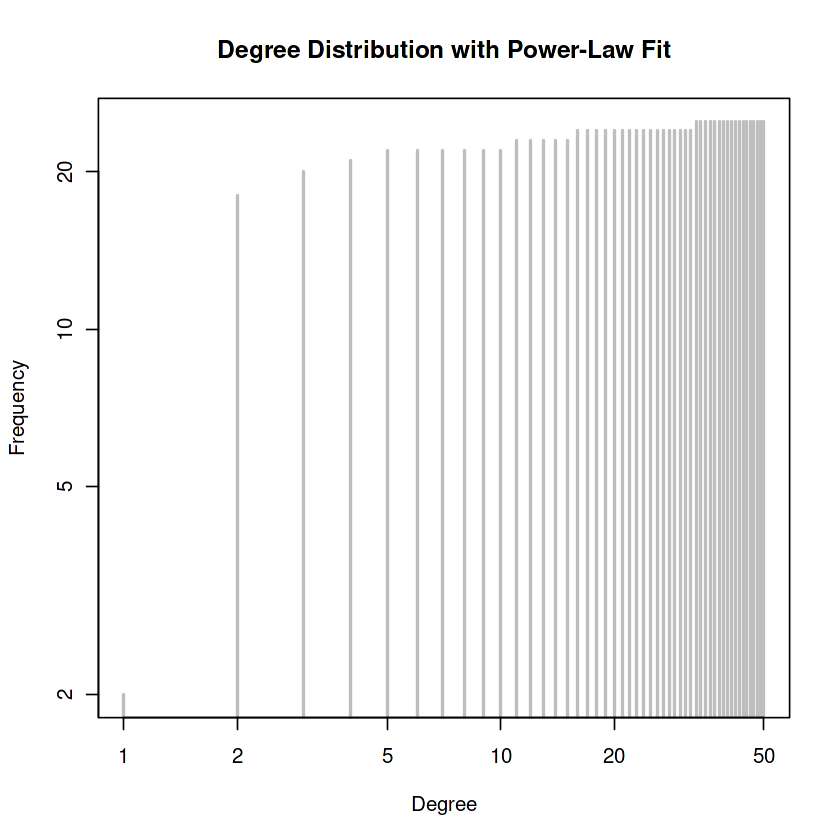

In [75]:
# Plot the degree distribution
plot(sort(degree_values), 
     type = "h", 
     lwd = 2, 
     main = "Degree Distribution with Power-Law Fit",
     xlab = "Degree", 
     ylab = "Frequency", 
     log = "xy", 
     col = "gray")

# Add the fitted power-law distribution to the plot
x <- seq(min(degree_values), max(degree_values), length.out = 100)
y <- (fit$alpha) * (x ^ -fit$alpha)
lines(x, y, col = "red", lwd = 2)

**6) each_edge()**

Graph perturbation using the each_edge function allows us to rewire edges in the graph, simulating changes in movie-user interactions. This helps test the robustness of a recommendation system by observing how slight changes in ratings or preferences impact system performance. Rewiring can mimic uncertainty in user-item relationships, helping evaluate how well the system adapts and maintains recommendations and network structure under dynamic changes.

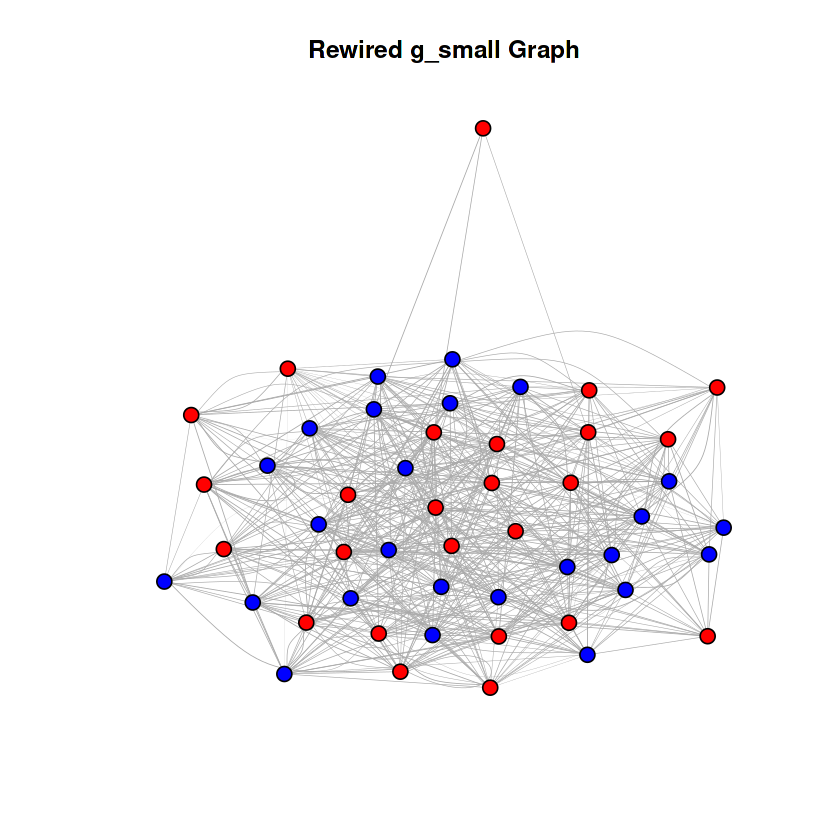

In [78]:
# Rewire the graph with a probability of 0.2 for each edge, allowing loops and multiple edges
# This step simulates changes in the graph structure by randomly rewiring edges
g_rewired <- rewire(g_small, each_edge(prob = 0.2, loops = TRUE, multiple = TRUE))

# Assign colors to the vertices based on whether they are users or movies
V(g_rewired)$color <- ifelse(grepl("^movie_", V(g_rewired)$name), "blue", "red")

# Plot the rewired graph 
plot(g_rewired, 
     main = "Rewired g_small Graph",
     vertex.size = 5,
     vertex.label = NA,  # Hide labels
     vertex.color = V(g_rewired)$color,
     edge.width = E(g_rewired)$weight / 10,  
     edge.arrow.size = 0.3, 
     layout = layout_with_fr(g_rewired))  

**7) coreness()**

If a user has a high coreness value, it means that the user has rated many movies and is well-connected in the graph.

In [82]:
# Calculate the coreness values for each vertex in the graph
# Coreness is a measure of how "core" a vertex is in the graph, based on its participation in k-core subgraphs
# A vertex's coreness indicates the largest k such that the vertex is part of the k-core (a subgraph where all nodes have at least k neighbors)
coreness_values <- coreness(g)

In [83]:
# View the values
coreness_values

2      3      4      5      8     10     12     13     18     26     36 
   183    594    237    101    155     53    583    399    186     39    108 
    43     47     50     51     56     57     64     66     67     69     73 
   408     70     81     19     30    345     53     79    126    149     39 
    75     77     82     86     90     93     95     96     98    109    110 
   463     45    155    148     33    121    200     55    128    253     48 
   111    112    120    125    127    130    132    143    147    152    158 
    23    133    547    243     58     71    254     35    197     91     78 
   160    162    163    166    167    171    175    176    186    187    188 
    96    101     52    533    122    589    526     44    107    636    139 
   197    198    200    201    211    216    217    221    224    226    227 
    83     52     20    294     97    359    400     66    159    522    158 
   228    229    230    233    235    236    242    243    249    256    257 
   274     92    399     70    146    215    157    509    111    202     83 
   259    261    265    279    285    292    296    297    298    301    302 
   119    185     96    146    489    157    378     37     20    234    132 
   304    312    318    319    321    323    325    329    339    340    341 
   321     55    393    161    621    110    105     49     25     24     41 
   350    353    354    355    358    359    360    364    368    369    370 
    76     20     41    320    148    338     84    249    289     34    374 
   371    372    373    379    380    381    386    392    396    402    405 
   132     28     74    278     27     29     62     36    290    323     31 
   407    409    411    413    414    416    421    422    424    426    428 
    88    200     73     50    198    196     62     33     49    636     78 
   431    434    435    436    437    439    440    446    447    449    459 
   583     92    240     52    206    226    484    499     66    172    164 
   461    462    464    468    469    472    477    484    494    495    497 
    70    403     55    179    311    295    526     52    568     41    133 
   501    502    506    508    512    513    515    516    519    521    525 
   134     54     44     25     51     49    179     44    473    247     25 
   526    527    531    537    540    541    543    548    549    551    553 
   222    190     82     30     30    592     50    636     54    286     22 
   559    561    567    572    573    580    581    582    589    592    593 
    56    390    443    529     24     71    211     28     23    251     27 
   597    598    601    605    606    607    609    610    611    613    623 
   503    323    129     86    608    178     57    190    211    188     51 
   624    626    627    628    630    631    634    636    637    638    644 
   115    636     43    373    332     43     73     84     26     28     36 
   646    647    649    653    654    658    663    664    670    672    675 
    42    310    316    621     38    101     94     27     54     73    129 
   676    680    683    686    694    695    697    700    702    705    707 
   230     70     22    156    399    589    202    159    233    467    486 
   709    712    714    722    723    726    727    728    732    733    736 
   462    198    306    167    138     33    179     21    104     22    196 
   738    741    746    749    752    756    757    764    765    768    770 
   291    329     36     73    120    410    636     53    154    328    184 
   772    773    775    785    788    791    793    795    796    798    803 
   348     30    192    161     60     31    265    290     24    164    605 
   805    807    809    811    815    818    821    828    830    833    834 
   483     70     20     22    362     32    208    539    144    157     67 
   835    836    837    838    839    840    844    845    847    848    854 
    47    356    202     24

**8) Cocitation**

Cocitation can be used to measure the relatedness of two entities based on how often they are cited together. This can be useful in a recommendation system, where we want to find related items.

In [85]:
# Calculate the cocitation of vertices in the graph
# Cocitation refers to the number of common neighbors (vertices) shared by pairs of vertices.
# This measure can be useful to identify pairs of vertices that are often mentioned or referenced together, 
# indicating their closeness or similarity in the graph structure.
head(cocitation(g_small))

,2177,8619,17783,18306,20055,24869,30879,33844,34987,36618,⋯,movie_1196,movie_1198,movie_1210,movie_1270,movie_2571,movie_2858,movie_2959,movie_4993,movie_5952,movie_7153
2177,0,25,25,22,25,24,24,25,25,25,⋯,0,0,0,0,0,0,0,0,0,0
8619,25,0,25,22,25,24,24,25,25,25,⋯,0,0,0,0,0,0,0,0,0,0
17783,25,25,0,22,25,24,24,25,25,25,⋯,0,0,0,0,0,0,0,0,0,0
18306,22,22,22,0,22,22,21,22,22,22,⋯,0,0,0,0,0,0,0,0,0,0
20055,25,25,25,22,0,24,24,25,25,25,⋯,0,0,0,0,0,0,0,0,0,0
24869,24,24,24,22,24,0,23,24,24,24,⋯,0,0,0,0,0,0,0,0,0,0


**9) max_flow()**

The max_flow function helps us determine how much recommendation flow (user interest) can pass from a user to a movie, considering ratings as the flow capacities. Higher flow values indicate stronger recommendations for a particular movie.

In [40]:
# Convert the undirected graph to a directed graph
g_directed <- as.directed(g_small)


In [46]:
# Now, let's assume we're calculating the maximum flow from a specific user (source) to a movie (target)
source_user <- 1  # User 1
target_movie <- "movie_1"  # Movie 1

# Calculate the maximum flow between the user and the movie
max_flow_result <- max_flow(g_directed, source_user, target_movie, capacity = E(g_directed)$weight)

# Print the result
print(max_flow_result)

$value
[1] 87

$flow
   [1] 4.5 4.5 4.5 4.0 5.0 4.5 4.5 4.0 4.5 4.0 4.0 4.5 4.5 4.0 4.5 4.5 0.5 3.5
  [19] 0.5 1.5 1.0 3.5 2.5 3.5 0.5 5.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [37] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.0 0.0 0.0 0.0
  [55] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [73] 0.0 0.0 0.0 2.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [91] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 [109] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.5 0.0
 [127] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 [145] 0.0 0.0 0.0 0.0 0.0 4.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 [163] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.0 0.0 0.0 0.0 0.0 0.0
 [181] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 [199] 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 [217] 0.0 0.0 0.0 0.0 0.0 0.0 

**10) make_line_graph()**

When we convert our bipartite graph g_small to a line graph using make_line_graph(g_small), each edge of the original graph (user–movie interaction) becomes a vertex in the new line graph.

So now, in the line graph, we no longer have separate user and movie nodes — we have new vertices that represent interactions like (user, movie). To separate them visually, we need to analyze the original edge data and tag these new vertices (in the line graph) accordingly.

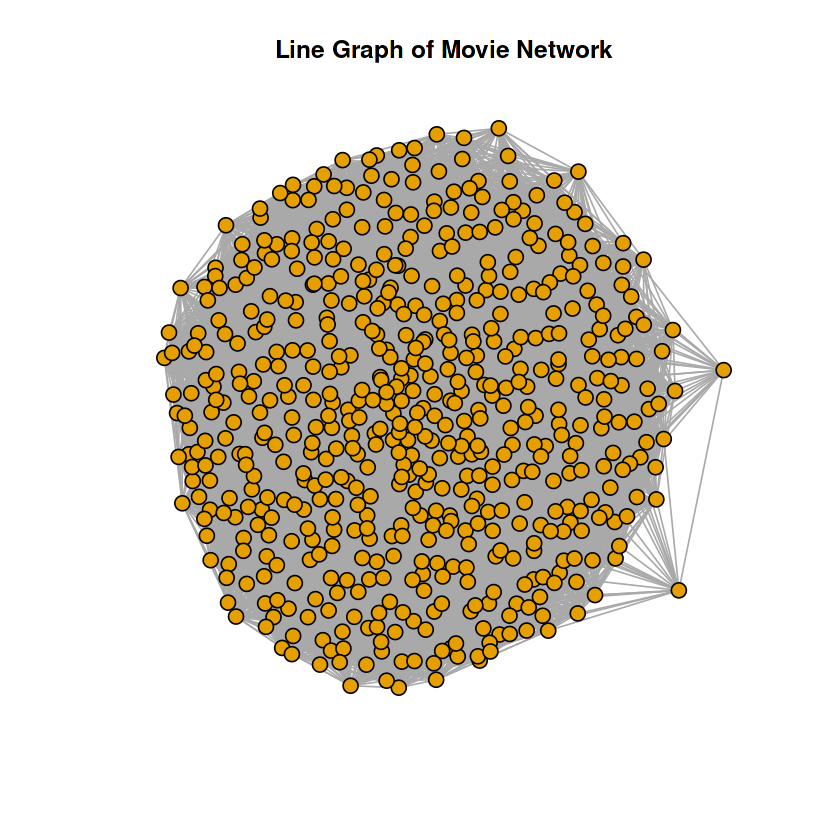

In [103]:
line_g <- make_line_graph(g_small)

# Now plot the line graph
plot(line_g, vertex.size = 5, vertex.label = NA, main = "Line Graph of Movie Network")

# Advanced Network Analysis with igraph

**a) Central Nodes**

In [87]:
# Degree centrality (number of connections)
deg_cent <- degree(g_small, mode = "all")
central_nodes_deg <- names(deg_cent[deg_cent == max(deg_cent)])

# Betweenness centrality
btwn_cent <- betweenness(g_small)
central_nodes_btwn <- names(btwn_cent[btwn_cent == max(btwn_cent)])

# Result
cat("Degree Central Node(s):", central_nodes_deg, "\n")
cat("Betweenness Central Node(s):", central_nodes_btwn, "\n")


Degree Central Node(s): 2177 8619 17783 20055 33844 34987 36618 61010 72315 80974 85757 92046 109731 110971 137293 143049 162047 movie_260 
Betweenness Central Node(s): 30879 


Degree Centrality: The nodes with the highest degree centrality (listed above) are the most connected nodes in the network. They have many direct neighbors, which means they are the most influential nodes based on the number of connections they have.

Betweenness Centrality: Node 30879 has the highest betweenness centrality, meaning that it plays a critical role in connecting different parts of the network. It acts as an intermediary node on the shortest paths between other nodes.

**b) Longest Paths**

In [48]:
# Use diameter to find length
g_diameter <- diameter(g_small, directed = FALSE)

# Find the path with max geodesic distance
longest_path <- get.diameter(g_small)

# Result
cat("Graph Diameter:", g_diameter, "\n")
cat("Longest Path:", longest_path, "\n")


Warning message:
“`get.diameter()` was deprecated in igraph 2.0.0.
ℹ Please use `get_diameter()` instead.”


Graph Diameter: 10.5 
Longest Path: 25 30 5 38 


Graph Diameter: A diameter of 10.5 indicates that the maximum shortest path distance between any two nodes in the graph is approximately 10.5 steps, meaning the graph is relatively large or has some isolated areas.

Longest Path: The path 25 → 30 → 5 → 38 represents the longest direct path in the graph with 3 edges between the nodes, showing which nodes are part of the longest sequence of connections in the network.

**c) Largest Cliques**

In [50]:
# Find all maximal cliques
all_cliques <- maximal.cliques(g_small)

# Largest clique size
max_clique_size <- max(sapply(all_cliques, length))

# Filter to find largest clique(s)
largest_cliques <- all_cliques[sapply(all_cliques, length) == max_clique_size]

# Print largest cliques
cat("Largest Clique Size:", max_clique_size, "\n")
cat("Number of Largest Cliques:", length(largest_cliques), "\n")


Largest Clique Size: 2 
Number of Largest Cliques: 584 


Largest Clique Size of 2: This means that the largest completely connected subgraph in the graph consists of just two nodes. The network is not highly interconnected in larger groups.

Number of Largest Cliques (584): There are 584 pairs of nodes in the graph that are fully connected to each other, indicating that most of the graph consists of isolated pairs rather than larger cliques.

**d) Ego**

In [88]:
# ego of the most central user (by degree)
ego_user <- central_nodes_deg[1]
ego_net <- ego(g_small, order = 1, nodes = ego_user, mode = "all")

# Display
cat("Ego network of", ego_user, ":\n")
print(ego_net)


Ego network of 2177 :
[[1]]
+ 26/50 vertices, named, from f34c7d9:
 [1] 2177       movie_1    movie_47   movie_50   movie_110  movie_260 
 [7] movie_296  movie_318  movie_356  movie_457  movie_480  movie_527 
[13] movie_589  movie_593  movie_608  movie_858  movie_1196 movie_1198
[19] movie_1210 movie_1270 movie_2571 movie_2858 movie_2959 movie_4993
[25] movie_5952 movie_7153



The ego network of node 2177 consists of 26 nodes directly connected to node 2177. These nodes are movies or entities that have a direct relationship with node 2177.

The list of names (movie_1, movie_47, movie_50, etc.) represents the neighbors of node 2177.

This type of analysis helps to understand how well-connected a specific node is within its immediate neighborhood, giving insight into the centrality and connectivity of that node in the larger graph.

**e) Power Centrality**

In [89]:
# igraph's version of power centrality
power_cent <- alpha_centrality(g_small, alpha = 0.1, exo = 1)

# View top nodes
sort(power_cent, decreasing = TRUE)[1:10]


75309  movie_260  movie_858      30879 movie_5952 movie_7153     136310 
 1.8791009  1.0146843  0.7435175  0.7181435  0.4780971  0.4298725  0.3997182 
     34987  movie_110      36618 
 0.3177240  0.2645521  0.1720233

Each of the numbers corresponds to the alpha centrality score of a node. These scores indicate how central each movie is in our graph, considering both direct and indirect connections. The higher the score, the more central or influential the node (movie) is in the network.

**f) Community Detection**

      2177       8619      17783      18306      20055      24869      30879 
         1          2          2          3          1          2          2 
     33844      34987      36618      61010      72315      80974      85757 
         3          2          1          3          3          1          1 
     92046     103611     109731     110971     136310     137293     143049 
         2          1          2          3          3          1          1 
    156480     162047      78849      75309    movie_1   movie_47   movie_50 
         3          3          2          2          3          3          3 
 movie_110  movie_260  movie_296  movie_318  movie_356  movie_457  movie_480 
         1          2          3          3          2          2          1 
 movie_527  movie_589  movie_593  movie_608  movie_858 movie_1196 movie_1198 
         3          1          1          2          2          2          2 
movie_1210 movie_1270 movie_2571 movie_2858 movie_2959 movie_499

Number of Communities: 3 


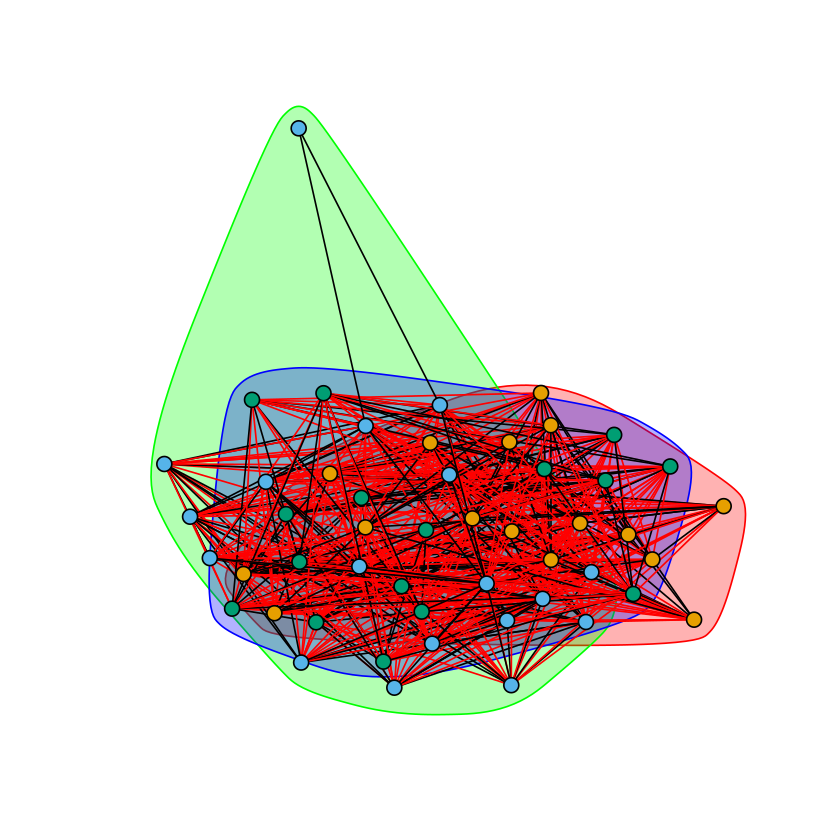

In [90]:
# Run Louvain community detection
comm_louvain <- cluster_louvain(g_small)

# Community membership
membership(comm_louvain)

# Number of communities
cat("Number of Communities:", length(comm_louvain), "\n")

# Plot
plot(comm_louvain, g_small, vertex.label = NA, vertex.size = 5)


Three Communities: The graph has been divided into three communities, and each movie belongs to one of these communities.

Community Membership: Each movie has been assigned a community label (1, 2, or 3), indicating which community it belongs to.

Graph Visualization: The plot generated shows these communities, typically using different colors to distinguish them.

# Visualization

The goal of the following code is to differentiate the vertices in the graph by assigning specific attributes based on their type. 

By categorizing vertices as either "movie" or "user", we can apply distinct colors (tomato for movies, skyblue for users) and shapes (square for movies, circle for users) to make the graph visualization clearer and more informative. 

This allows us to visually distinguish between the two types of nodes before plotting the graph.

In [92]:
# Assign vertex type
V(g_small)$type <- ifelse(grepl("^movie_", V(g_small)$name), "movie", "user")

# Assign colors
V(g_small)$color <- ifelse(V(g_small)$type == "movie", "tomato", "skyblue")

# Assign shapes 
V(g_small)$shape <- ifelse(V(g_small)$type == "movie", "square", "circle")


The goal of the following code is to visually differentiate edges based on their weight (rating). 

Edges with a weight of 4 or greater are colored dark green, edges with a weight of 3 are colored orange,and edges with a weight less than 3 are colored grey. This helps highlight stronger relationships in the graph.

Additionally, edges with a weight less than 3 are made dashed (lty = 2), while edges with a weight of 3 or more are solid (lty = 1). 

This further emphasizes the strength of the relationships between nodes.

In [93]:
# Edge color based on rating weight
E(g_small)$color <- ifelse(E(g_small)$weight >= 4, "darkgreen",
                           ifelse(E(g_small)$weight >= 3, "orange", "grey"))

# Make lower-weight edges dashed
E(g_small)$lty <- ifelse(E(g_small)$weight < 3, 2, 1)  # 1 = solid, 2 = dashed


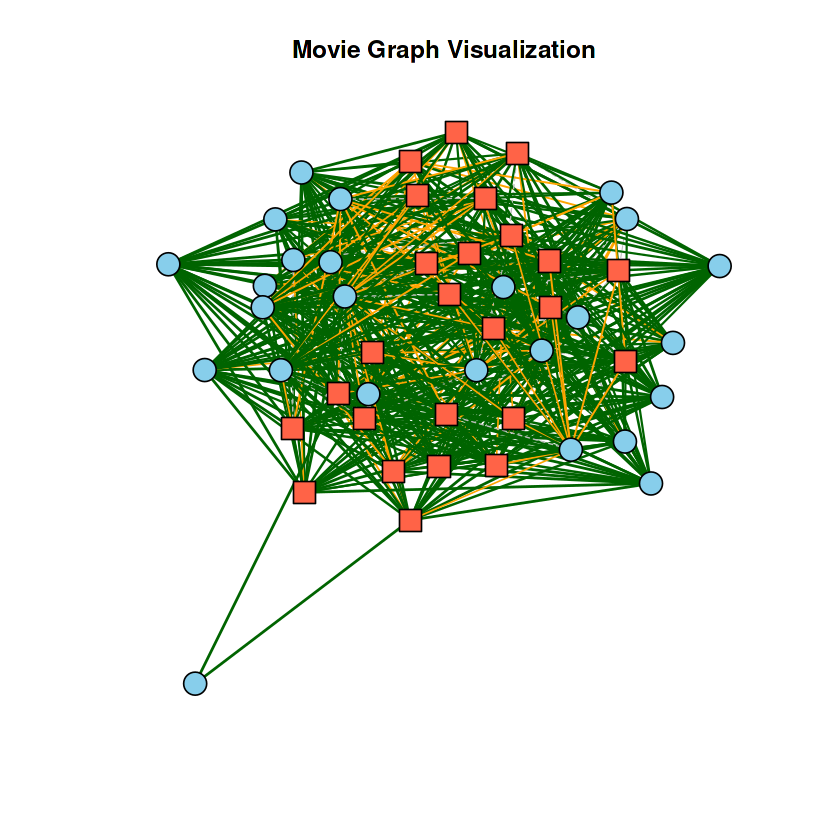

In [95]:
# Plot the graph `g_small` with customizations for visualization
plot(g_small,
     # Set the size of the vertices (nodes) to 8
     vertex.size = 8,
     # Remove vertex labels (set to NA)
     vertex.label = NA,
     # Set vertex color based on the predefined `color` attribute
     vertex.color = V(g_small)$color,
     # Set vertex shape based on the predefined `shape` attribute (square for movies, circle for users)
     vertex.shape = V(g_small)$shape,
     # Adjust edge width based on the weight attribute (edges with higher weights will be thicker)
     edge.width = E(g_small)$weight / 3,
     # Set edge color based on the predefined `color` attribute (differentiates based on weight)
     edge.color = E(g_small)$color,
     # Set edge line type (dashed for lower weights, solid for higher weights)
     edge.lty = E(g_small)$lty,
     # Use the Kamada-Kawai layout algorithm for positioning vertices
     layout = layout_with_kk,
     # Set the title of the graph
     main = "Movie Graph Visualization")
